In [2]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

# donotdelete = []
print(sys.version)

3.6.6 (default, Mar 29 2019, 00:03:27) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [4]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
bkg_path = "/nfshome/christiw/llp/jet_timing_studies_root/trackless/"
# bkg_path = "/nfshome/christiw/llp/jet_timing_studies_root/gammaMax_p/"

lumi = 137000 #in pb-1
# fpath_bkg['WJetsToLNu'] = bkg_path+"jet_timing_studies_ntuple_RunIIFall17DRPremix_WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2.root"

fpath_bkg['QCD'] = bkg_path+"jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8.root"
fpath_bkg['bbbb_mh125_ctau1'] = bkg_path+'jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl1000_ev100000.root'
fpath_bkg['bbbb_mh2000_ctau1'] = bkg_path+'jet_timing_studies_ntuple_bbbb_vh_ISR_mh2000_mx975_pl1000_ev100000.root'
fpath_bkg['bbbb_mh125_ctau10'] = bkg_path+'jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl10000_ev100000.root'
fpath_bkg['bbbb_mh2000_ctau10'] = bkg_path+'jet_timing_studies_ntuple_bbbb_vh_ISR_mh2000_mx975_pl10000_ev100000.root'

# process['glueBall'] = 'pp #rightarrow  #rightarrow bbbb'


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['ntuples']['llp']
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["jetPt"].array()
    print (a[:-1][0])
    print(a.shape)

QCD /nfshome/christiw/llp/jet_timing_studies_root/trackless/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8.root
[231.354     87.641464  56.886036]
(59068,)
bbbb_mh125_ctau1 /nfshome/christiw/llp/jet_timing_studies_root/trackless/jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl1000_ev100000.root
[64.42451  51.139175 37.67556 ]
(57991,)
bbbb_mh2000_ctau1 /nfshome/christiw/llp/jet_timing_studies_root/trackless/jet_timing_studies_ntuple_bbbb_vh_ISR_mh2000_mx975_pl1000_ev100000.root
[539.81354 272.1115  250.49152 248.0052  144.67659 101.62265]
(26133,)
bbbb_mh125_ctau10 /nfshome/christiw/llp/jet_timing_studies_root/trackless/jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl10000_ev100000.root
[30.621801]
(82611,)
bbbb_mh2000_ctau10 /nfshome/christiw/llp/jet_timing_studies_root/trackless/jet_timing_studies_ntuple_bbbb_vh_ISR_mh2000_mx975_pl10000_ev100000.root
[201.818    156.99211  115.86546  102.78594   35.552967]
(25959,)


In [5]:
legend = {}
legend['QCD'] = 'QCD p_{T}170-300 GeV'
legend['bbbb_mh125_ctau1'] = 'Signal (m_{h} ,m_{x})=(125, 50) GeV, c#tau = 1 m'
legend['bbbb_mh2000_ctau1'] = 'Signal (m_{h} ,m_{x})=(2000, 975) GeV, c#tau = 1 m'
legend['bbbb_mh125_ctau10'] = 'Signal (m_{h} ,m_{x})=(125, 50) GeV, c#tau = 10 m'
legend['bbbb_mh2000_ctau10'] = 'Signal (m_{h} ,m_{x})=(2000, 975) GeV, c#tau = 10 m'
trigger_names_file = '/home/cms/Desktop/LLP/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names_file = '/nfshome/christiw/llp/cms_lpc_llp/jet_timing_studies/data/trigger_names_llp_v1.dat'

trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
    trigger_paths = [87,135] #PFMET120


# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET

In [42]:
ptcut = 20
jetGammaMax_ET = {}
CHEF = {}
jetTMF_all = {}
jetTMF_pv = {}
jetMinDeltaRPVTracks = {}
for k,T in tree_bkg.items():
    
    CHEF[k] = []
    jetGammaMax_ET[k] = []
    jetTMF_all[k] = []
    jetTMF_pv[k] = []
    jetMinDeltaRPVTracks[k] = []
    
    nJets = T['nJets'].array()
    gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index'].array()
    jetMinDeltaRPVTracks_temp = T['jetMinDeltaRPVTracks'].array()
    CHEF_temp = T['jetChargedHadronEnergyFraction'].array()
    jetGammaMax_ET_temp = T['jetGammaMax_ET'].array()
    jetTMF_all_temp = T['jetPtAllTracks'].array()/T['jetEt'].array()
    jetTMF_pv_temp = T['jetPtAllPVTracks'].array()/T['jetEt'].array()
    for ev in range(len(nJets)):
        for j in range(nJets[ev]):
            if not k=='QCD' and j not in  gLLP_daughter_match_jet_index[ev]: continue
            CHEF[k].append(CHEF_temp[ev][j])
            jetGammaMax_ET[k].append(jetGammaMax_ET_temp[ev][j])
            jetTMF_all[k].append(jetTMF_all_temp[ev][j])
            jetTMF_pv[k].append(jetTMF_pv_temp[ev][j])
            jetMinDeltaRPVTracks[k].append(jetMinDeltaRPVTracks_temp[ev][j])
    CHEF[k] = np.array(CHEF[k])
    jetGammaMax_ET[k] = np.array(jetGammaMax_ET[k])
    jetTMF_all[k] = np.array(jetTMF_all[k])
    jetTMF_pv[k] = np.array(jetTMF_pv[k])
    jetMinDeltaRPVTracks[k] = np.array(jetMinDeltaRPVTracks[k])
    print(k)

QCD
bbbb_mh125_ctau1
bbbb_mh2000_ctau1
bbbb_mh125_ctau10
bbbb_mh2000_ctau10


In [ ]:
# plot only the matched jets
ptcut = 20

calojetAlphaMax = {}
calojetBetaMax = {}
calojetGammaMax = {}
calojetGammaMax_EM = {}
calojetGammaMax_ET = {}
calojetGammaMax_Hadronic = {}
log10calojetMedianIP = {}
calojetMinDeltaRAllTracks = {}
calojetMinDeltaRPVTracks = {}
calojetPt = {}
nCaloJets = {}
calojetEta = {}
jetAlphaMax = {}
jetBetaMax = {}
jetGammaMax = {}
jetGammaMax_EM = {}
jetGammaMax_Hadronic = {}
log10jetMedianIP = {}
jetMinDeltaRAllTracks = {}
jetMinDeltaRPVTracks = {}
jetPt = {}
nrechits = {}
CEF = {}
calojetRechitT = {}
jetRechitT = {}
jet_n_rechits = {}
calojetNRechits = {}
calojetRechitT_rms = {}
jet_rechit_T_rms_Ecut0p5 = {}
nJets = {}
jetEta = {}
jetGammaMax_ET = {}
jetRechitE = {}
calojetGammaMax_P = {}
jetGammaMax_P = {}
CHEF = {}
jet_rechits_E = {}
jetTMF_all = {}
nPU = {}
jetTMF_pv = {}
for k,T in tree_bkg.items():

#     nCaloJets[k] = T['nCaloJets'].array()
#     sel = nCaloJets[k]>=2
#     calojetPt[k] = T['calojetPt'].array()[sel][:,0]

#     calojetEta[k] = T['calojetEta'].array()[sel][:,0]
#     calojetGammaMax[k] = T['calojetGammaMax'].array()[sel][:,0]
#     calojetGammaMax_ET[k] = T['calojetGammaMax_ET'].array()[sel][:,0]
#     calojetGammaMax_P[k] = T['calojetGammaMax_P'].array()[sel][:,0]
#     calojetMinDeltaRPVTracks[k] = T['calojetMinDeltaRPVTracks'].array()[sel][:,0]




    nJets[k] = T['nJets'].array()
    sel = nJets[k]>=2
    jetEta[k] = T['jetEta'].array()[sel][:,0]
    jetPt[k] = T['jetPt'].array()[sel][:,0]

    CEF[k] = T['jetChargedEMEnergyFraction'].array()[sel][:,0] + T['jetChargedHadronEnergyFraction'].array()[sel][:,0]
    jetRechitE[k] =  T['jet_rechit_E_Ecut0p5'].array()[sel][:,0]
    jetRechitT[k] =  T['jet_rechit_T_Ecut0p5'].array()[sel][:,0]
    jet_n_rechits[k] = T['jet_n_rechits'].array()[sel][:,0]
    jetGammaMax[k] = T['jetGammaMax'].array()[sel][:,0]
    jetGammaMax_P[k] = T['jetGammaMax_P'].array()[sel][:,0]
    jetMinDeltaRPVTracks[k] = T['jetMinDeltaRPVTracks'].array()[sel][:,0]
    
#     jetGammaMax_ET[k] = T['jetGammaMax_ET'].array()[sel][:,0]*T['jetEt'].array()[sel][:,0]/T['jetPt'].array()[sel][:,0]
    CHEF[k] = T['jetChargedHadronEnergyFraction'].array()[sel][:,0]
    jetGammaMax_ET[k] = T['jetGammaMax_ET'].array()[sel][:,0]

    jetTMF_all[k] = T['jetPtAllTracks'].array()[sel][:,0]/T['jetEt'].array()[sel][:,0]
    jetTMF_pv[k] = T['jetPtAllPVTracks'].array()[sel][:,0]/T['jetEt'].array()[sel][:,0]
#     jetTMF_all[k] = T['jetPtAllTracks'].array()[sel][:,0]/T['jetPt'].array()[sel][:,0]
#     jetTMF_pv[k] = T['jetPtAllPVTracks'].array()[sel][:,0]/T['jetPt'].array()[sel][:,0]
    nPU[k] = T['nPU'].array()[sel]
    
#     jetEta[k] = np.concatenate(T['jetEta'].array()[sel]).ravel()
#     CEF[k] = np.concatenate(T['jetChargedEMEnergyFraction'].array()[sel]).ravel() + np.concatenate(T['jetChargedHadronEnergyFraction'].array()[sel]).ravel()
#     jetRechitE[k] =  np.concatenate(T['jet_rechit_E_Ecut0p5'].array()[sel]).ravel()
#     jetRechitT[k] =  np.concatenate(T['jet_rechit_T_Ecut0p5'].array()[sel]).ravel()
#     jet_n_rechits[k] = np.concatenate(T['jet_n_rechits'].array()[sel]).ravel()
#     jetGammaMax[k] = np.concatenate(T['jetGammaMax'].array()[sel]).ravel()
#     jetGammaMax_ET[k] = np.concatenate(T['jetGammaMax_ET'].array()[sel]).ravel()
    print(k,len(CEF[k]))
#     print(jetPt[k][:10])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_jetGammaMax_ET_nPU.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_CHEF_nPU.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_jetTMF_all_nPU.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_jetTMF_pv_nPU.pdf has been created


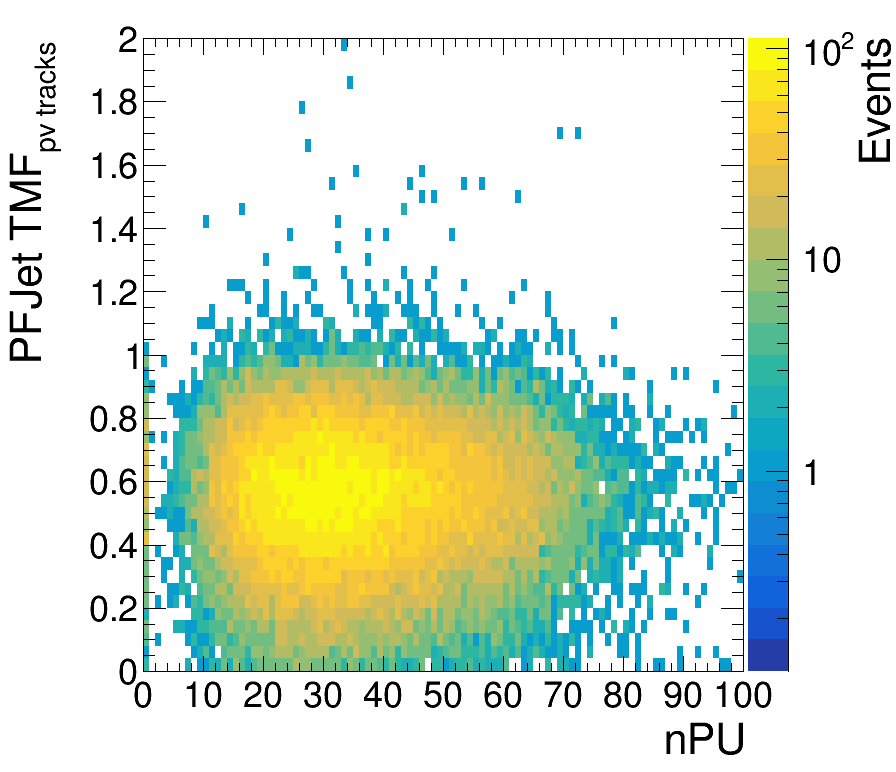

In [345]:
# trackless variables vs. pileup

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.60,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
k = 'QCD'
sel = np.abs(jetEta[k])<2.0
sel = np.logical_and(sel,np.abs(jetPt[k])>20)
sel = np.logical_and(sel,jetRechitE[k]>10)
h['jetGammaMax_ET'] = create_TH2D(np.column_stack((nPU[k][sel],jetGammaMax_ET[k][sel])), axis_title = ['nPU','PFJet TMF_{MAX}','Events'], binning=[100,0,100,50,0,2])
h['CHEF'] = create_TH2D(np.column_stack((nPU[k][sel],CHEF[k][sel])), axis_title = ['nPU','CHEF','Events'], binning=[100,0,100,50,0,2])
h['jetTMF_all'] = create_TH2D(np.column_stack((nPU[k][sel],jetTMF_all[k][sel])), axis_title = ['nPU','PFJet TMF_{all tracks}','Events'], binning=[100,0,100,50,0,2])
h['jetTMF_pv'] = create_TH2D(np.column_stack((nPU[k][sel],jetTMF_pv[k][sel])), axis_title = ['nPU','PFJet TMF_{pv tracks}','Events'], binning=[100,0,100,50,0,2])

#     currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
#         h[k].SetMaximum(10*currentMax)
#         h[k].SetMinimum(1)


# leg.AddEntry(h['CHEF'], 'PF Jet CHEF')
# leg.AddEntry(h['jetGammaMax_ET'], 'PF Jet TMF_{MAX}')
# leg.AddEntry(h['jetTMF_all'], 'PF Jet TMF_{all tracks}')
# leg.AddEntry(h['jetTMF_pv'], 'PF Jet TMF_{PV tracks}')
for k,v in h.items():
    h[k].Draw('colz')

    c.SetRightMargin(0.17)

# leg.Draw()


    c.SetLogz()
    c.Draw()
    c.SaveAs('../plots/trackless/QCD_'+k+'_nPU.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_pfjet_trackless.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../plots/trackless/bbbb_mh125_ctau1_pfjet_trackless.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing

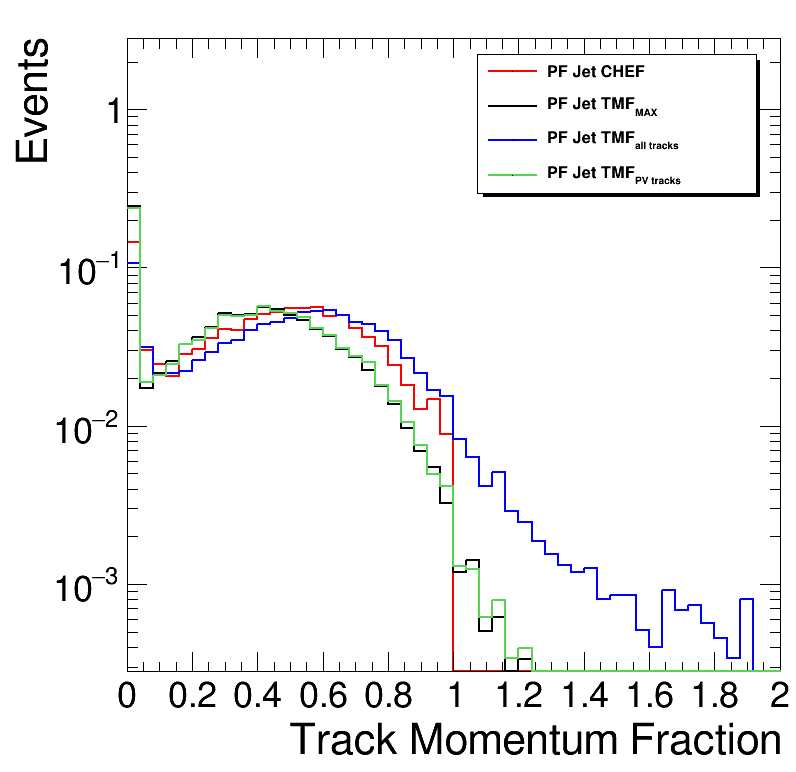

In [8]:
# plot calojet Time for different signal vs. bkg

for k,v in jetGammaMax_ET.items():
    c = rt.TCanvas('c','c', 800, 800)
    h = {}
    # leg = rt.TLegend(0.50,0.75,0.97,0.93)
    leg = rt.TLegend(0.60,0.75,0.95,0.93)
    leg.SetTextSize(0.022)
    # leg.SetTextFont(42)
    leg.SetEntrySeparation(0.01)
    max_y = 0
#     k = 'QCD'
    sel = np.abs(jetEta[k])<2.0
    sel = np.logical_and(sel,np.abs(jetPt[k])>20)
    sel = np.logical_and(sel,jetRechitE[k]>10)

    h['jetGammaMax_ET'] = create_TH1D(jetGammaMax_ET[k][sel],axis_title = ['Track Momentum Fraction','Events'], binning=[50,0,2])
    h['CHEF'] = create_TH1D(CHEF[k][sel],axis_title =['Track Momentum Fraction','Events'], binning=[50,0,2])
    h['jetTMF_all'] = create_TH1D(jetTMF_all[k][sel],axis_title = ['Track Momentum Fraction','Events'], binning=[50,0,2])
    h['jetTMF_pv'] = create_TH1D(jetTMF_pv[k][sel],axis_title = ['Track Momentum Fraction','Events'], binning=[50,0,2])

    #     currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    #     if currentMax > max_y:
    #         max_y = currentMax
    #         h[k].SetMaximum(10*currentMax)
    #         h[k].SetMinimum(1)
    h['CHEF'].SetMaximum(50000)
    h['CHEF'].SetMinimum(5)


    h['jetGammaMax_ET'].SetLineColor(std_color_list[0])
    h['CHEF'].SetLineColor(std_color_list[1])
    h['jetTMF_all'].SetLineColor(std_color_list[2])
    h['jetTMF_pv'].SetLineColor(std_color_list[3])

    leg.AddEntry(h['CHEF'], 'PF Jet CHEF')
    leg.AddEntry(h['jetGammaMax_ET'], 'PF Jet TMF_{MAX}')
    leg.AddEntry(h['jetTMF_all'], 'PF Jet TMF_{all tracks}')
    leg.AddEntry(h['jetTMF_pv'], 'PF Jet TMF_{PV tracks}')

    h['CHEF'].DrawNormalized('same')
    h['jetGammaMax_ET'].DrawNormalized('same')
    h['jetTMF_all'].DrawNormalized('same')
    h['jetTMF_pv'].DrawNormalized('same')

    # c.SetRightMargin(0.17)

    leg.Draw()


    c.SetLogy()
    c.Draw()
    c.SaveAs('../plots/trackless/'+k+'_pfjet_trackless.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


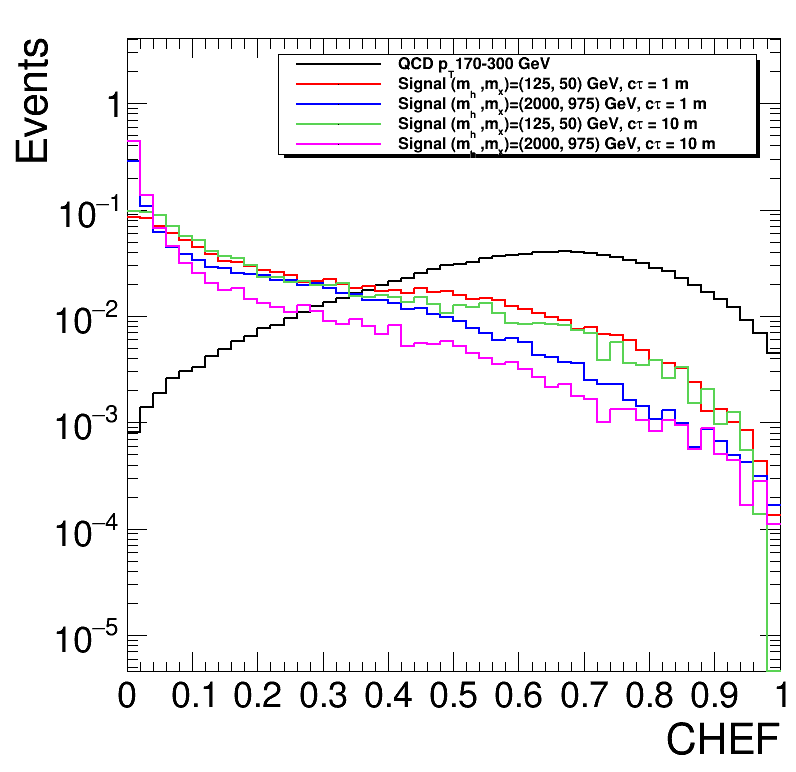

In [43]:
# plot calojet Time for different signal vs. bkg
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.35,0.80,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
for k,v in CHEF.items():
# k = 'bbbb_mh2000_ctau1'
#     sel = np.abs(jetEta[k])<2
#     sel = np.logical_and(sel,np.abs(jetPt[k])>20)
#     sel = np.logical_and(sel,jetRechitE[k]>10)

    h[k] = create_TH1D(CHEF[k],axis_title =['CHEF','Events'], binning=[50,0,1])

    currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[k].SetMaximum(100*currentMax)
        h[k].SetMinimum(1)

    h[k].SetLineColor(std_color_list[i])

    leg.AddEntry(h[k], legend[k])

    h[k].DrawNormalized('same')

    i+=1
# c.SetRightMargin(0.17)

leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/trackless/calojetRechitT_rms.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


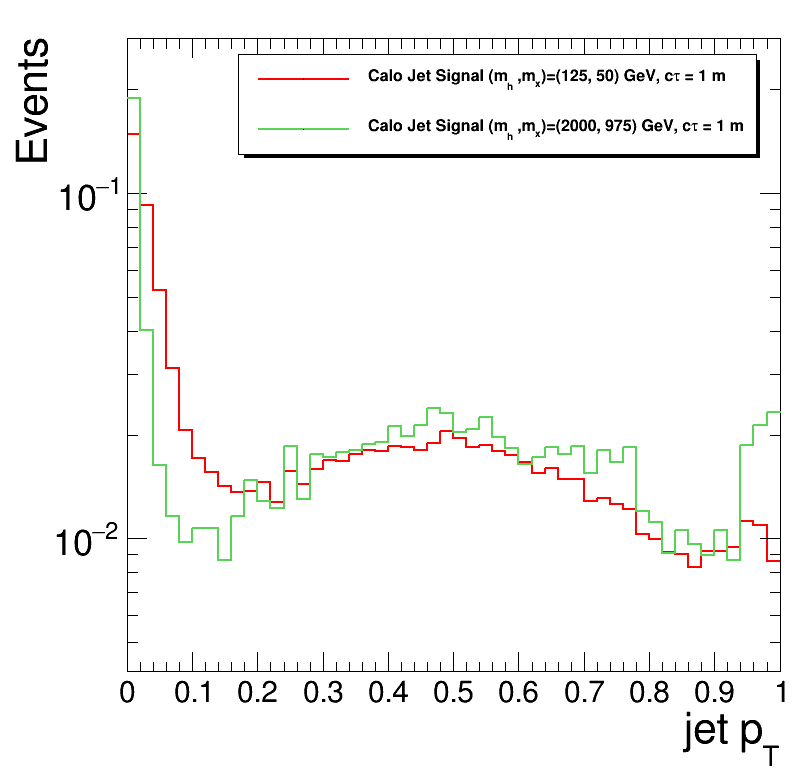

In [238]:
# plot calojet Time for different signal vs. bkg
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.30,0.80,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
j = 0
# h['mh125_pf'] = create_TH1D(jetPt['bbbb_mh125_ctau1'],axis_title = ['jet p_{T}','Events'], binning=[50,0,2000])
h['mh125_calo'] = create_TH1D(jetGammaMax_ET['bbbb_mh125_ctau1'],axis_title = ['jet p_{T}','Events'], binning=[50,0,1])
# h['mh2000_pf'] = create_TH1D(jetPt['bbbb_mh2000_ctau1'],axis_title = ['jet p_{T}','Events'], binning=[50,0,2000])
h['mh2000_calo'] = create_TH1D(jetGammaMax_ET['bbbb_mh125_ctau1'][jetPt['bbbb_mh125_ctau1']>100],axis_title = ['jet p_{T}','Events'], binning=[50,0,1])

#     currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
#         h[k].SetMaximum(10*currentMax)
#         h[k].SetMinimum(1)
h['mh125_calo'].GetXaxis().SetLabelSize(0.042)
# h['mh125_pf'].SetLineColor(std_color_list[0])
h['mh125_calo'].SetLineColor(std_color_list[1])
# h['mh2000_pf'].SetLineColor(std_color_list[2])
h['mh2000_calo'].SetLineColor(std_color_list[3])

# leg.AddEntry(h['mh125_pf'], 'PF Jet '+legend['bbbb_mh125_ctau1'])
leg.AddEntry(h['mh125_calo'], 'Calo Jet '+legend['bbbb_mh125_ctau1'])
# leg.AddEntry(h['mh2000_pf'], 'PF Jet '+legend['bbbb_mh2000_ctau1'])
leg.AddEntry(h['mh2000_calo'], 'Calo Jet '+legend['bbbb_mh2000_ctau1'])

# h['mh125_pf'].DrawNormalized('same')
h['mh125_calo'].DrawNormalized('same')
# h['mh2000_pf'].DrawNormalized('same')
h['mh2000_calo'].DrawNormalized('same')

# c.SetRightMargin(0.17)

leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/trackless/calojetRechitT_rms.pdf')

In [135]:
# plot calojet Time for different signal vs. bkg
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.65,0.80,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
j = 0
for k,v in jet_n_rechits.items():
    sel = np.logical_and(calojetNRechits[k]>5, calojetRechitT_rms[k]<5)
    h[k] = create_TH1D(v,axis_title = ['t_{reco} [ns]','Events'], binning=[50,0,500])
    
    currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[k].SetMaximum(10*currentMax)
        h[k].SetMinimum(1)
    h[k].GetXaxis().SetLabelSize(0.045)
    h[k].SetLineColor(std_color_list[j])
    leg.AddEntry(h[k], k)
    h[k].DrawNormalized('same')
    j+=1

# c.SetRightMargin(0.17)

leg.Draw()


c.SetLogy()
c.Draw()
c.SaveAs('../plots/trackless/calojetRechitT_rms.pdf')

KeyError: 'QCD'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_jetGammaMax_ET_CHEF.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_jetTMF_all_CHEF.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/trackless/QCD_jetTMF_pv_CHEF.pdf has been created


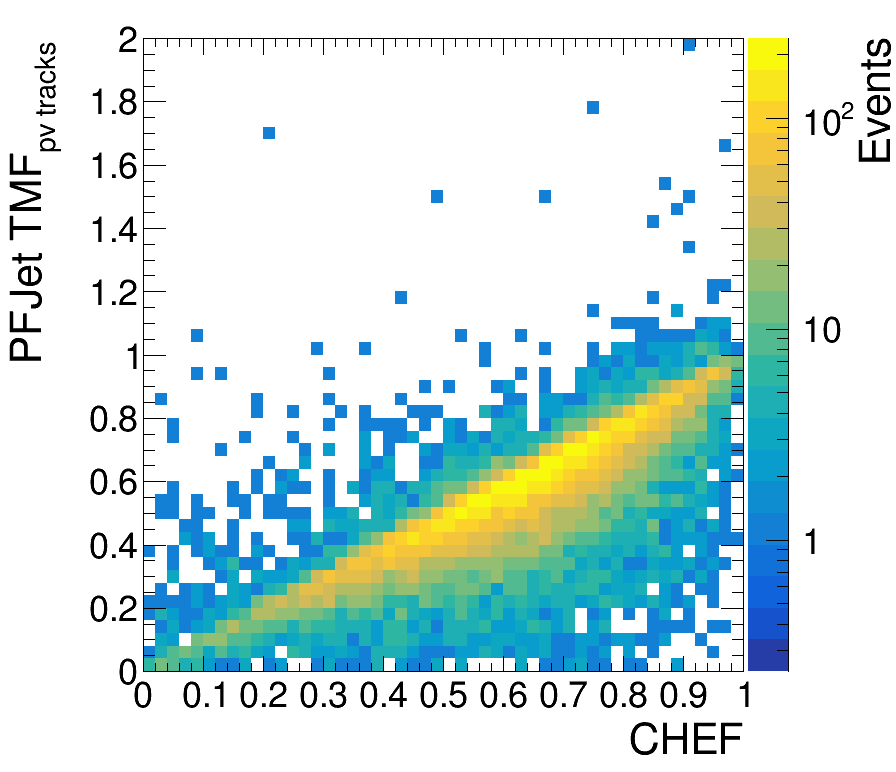

In [344]:
# Plotting correlation between those variables

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.60,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
k = 'QCD'
sel = np.abs(jetEta[k])<2.0
sel = np.logical_and(sel,np.abs(jetPt[k])>200)
sel = np.logical_and(sel,jetRechitE[k]>10)
h['jetGammaMax_ET'] = create_TH2D(np.column_stack((CHEF[k][sel],jetGammaMax_ET[k][sel])), axis_title = ['CHEF','PFJet TMF_{MAX}','Events'], binning=[50,0,1,50,0,2])
h['jetTMF_all'] = create_TH2D(np.column_stack((CHEF[k][sel],jetTMF_all[k][sel])), axis_title = ['CHEF','PFJet TMF_{all tracks}','Events'], binning=[50,0,1,50,0,2])
h['jetTMF_pv'] = create_TH2D(np.column_stack((CHEF[k][sel],jetTMF_pv[k][sel])), axis_title = ['CHEF','PFJet TMF_{pv tracks}','Events'], binning=[50,0,1,50,0,2])

#     currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
#         h[k].SetMaximum(10*currentMax)
#         h[k].SetMinimum(1)


# leg.AddEntry(h['CHEF'], 'PF Jet CHEF')
# leg.AddEntry(h['jetGammaMax_ET'], 'PF Jet TMF_{MAX}')
# leg.AddEntry(h['jetTMF_all'], 'PF Jet TMF_{all tracks}')
# leg.AddEntry(h['jetTMF_pv'], 'PF Jet TMF_{PV tracks}')
for k,v in h.items():
    h[k].Draw('colz')

    c.SetRightMargin(0.17)

# leg.Draw()


    c.SetLogz()
    c.Draw()
    c.SaveAs('../plots/trackless/QCD_'+k+'_CHEF.pdf')


(205785,)
(179509,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../plots/trackless/treco_pfvscalo.pdf has been created


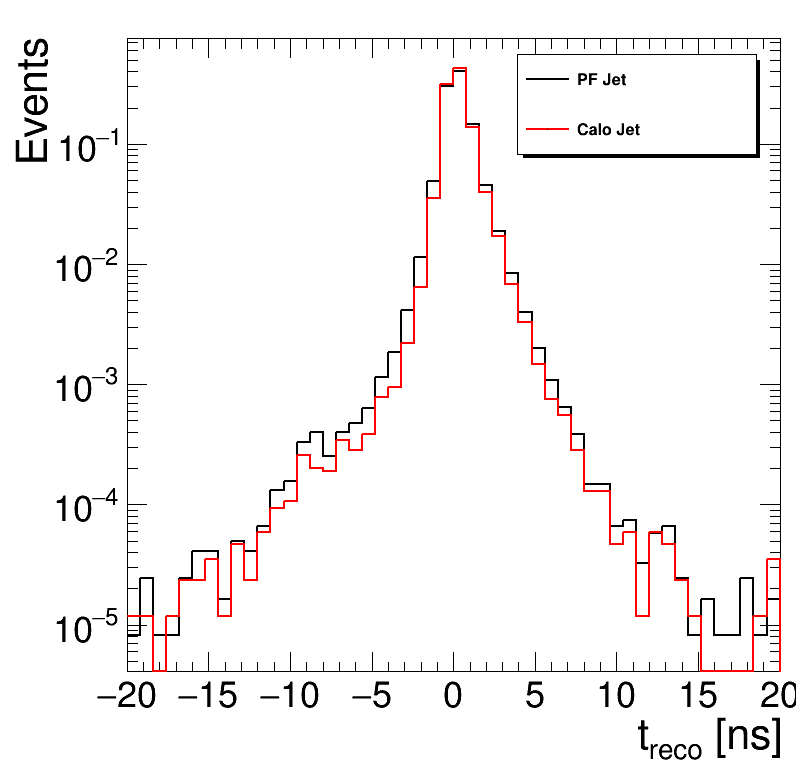

In [15]:
# Plotting pf time vs calo time

max_y = 0
j = 0
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.65,0.80,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
print(jetRechitT[k].shape)
print(calojetRechitT[k].shape)
h['pf'] = create_TH1D(jetRechitT['bbbb_mh125_ctau1'], axis_title = ['t_{reco} [ns]','Events'], binning=[50,-20,20])

h['calo'] = create_TH1D(calojetRechitT['bbbb_mh125_ctau1'], axis_title = ['t_{reco} [ns]','Events'], binning=[50,-20,20])
   
h['pf'].SetLineColor(std_color_list[0])
h['calo'].SetLineColor(std_color_list[1])

leg.AddEntry(h['pf'], 'PF Jet')
leg.AddEntry(h['calo'], 'Calo Jet')

h['pf'].DrawNormalized('')
h['calo'].DrawNormalized('same')

# c.SetRightMargin(0.17)

leg.Draw()


c.SetLogy()
c.Draw()
c.SaveAs('../plots/trackless/treco_pfvscalo.pdf')



5 5 5 5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file ../plots/trackless/CHEF_signalbkg.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file ../plots/trackless/pfjetGammaMax_ET_signalbkg.png has been created
Warning in <TCanvas::Constructor>: Del

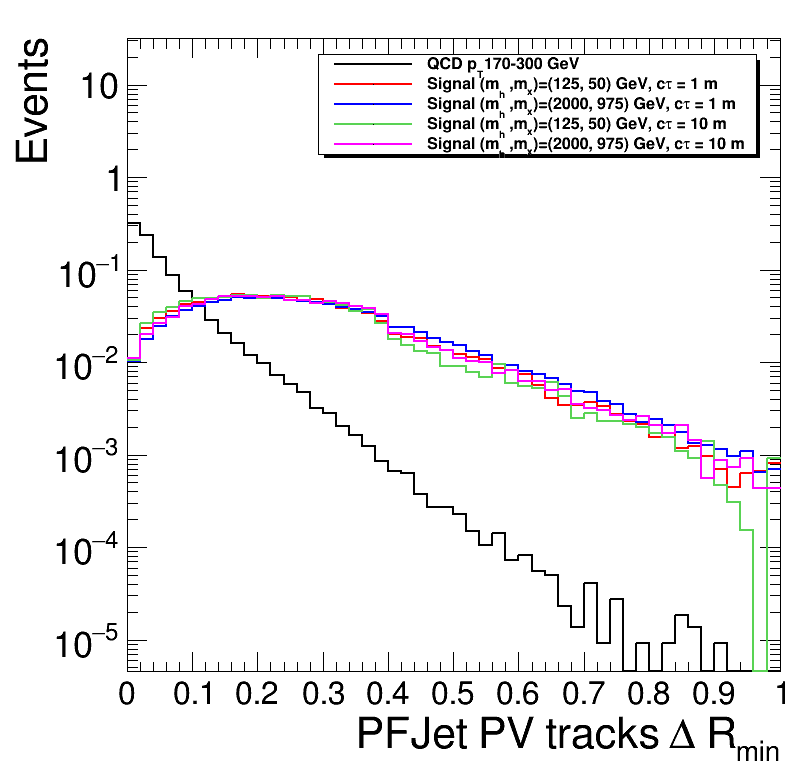

In [47]:
# Plotting mass

var_calo = [calojetAlphaMax,calojetBetaMax,calojetGammaMax_P,calojetGammaMax_EM,calojetGammaMax_Hadronic,calojetGammaMax_ET,calojetGammaMax, log10calojetMedianIP, calojetMinDeltaRAllTracks,calojetMinDeltaRPVTracks]
axis_calo = [['caloJet #alpha_{Max}','Events'],['caloJet #beta_{Max}','Events'],['Track Momentum Fraction','Events'],['Track p_{T} Fraction_{EM}','Events'],['Track p_{T} Fraction_{Had}','Events'],['Track p_{T} Fraction_{ET}','Events'],['Track p_{T} Fraction','Events'],['caloJet log10(\hat{IP}_{sig})','Events'],['caloJet all tracks #Delta R_{min}','Events'],['caloJet PV tracks #Delta R_{min}','Events']]
name_calo = ['calojetAlphaMax','calojetBetaMax','calojetGammaMax_P','calojetGammaMax_EM','calojetGammaMax_Hadronic','calojetGammaMax_ET','calojetGammaMax', 'calojetMedianIP', 'calojetMinDeltaRAllTracks','calojetMinDeltaRPVTracks']
bins_calo = [[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,-1,3],[50,0,1],[50,0,1]]

# var_pf = [CEF,CHEF,jetAlphaMax,jetBetaMax,jetGammaMax_P,jetGammaMax_EM,jetGammaMax_Hadronic,jetGammaMax, jetGammaMax_ET,log10jetMedianIP, jetMinDeltaRAllTracks,jetMinDeltaRPVTracks,]
# axis_pf = [['CEF','Events'],['CHEF','Events'],['PFJet #alpha_{Max}','Events'],['PFJet #beta_{Max}','Events'],['PFJet Track Momentum Fraction','Events'],['PFJet Track p_{T} Fraction_{EM}','Events'],['PFJet Track p_{T} Fraction_{Had}','Events'],['PFJet Track p_{T} Fraction','Events'],['PFJet Track p_{T} Fraction_{ET}','Events'],['PFJet log10(\hat{IP}_{sig})','Events'],['PFJet all tracks #Delta R_{min}','Events'],['PFJet PV tracks #Delta R_{min}','Events']]
# name_pf = ['pfCEF','pfCHEF','pfjetAlphaMax','pfjetBetaMax','pfjetGammaMax_P','pfjetGammaMax_EM','pfjetGammaMax_Hadronic','pfjetGammaMax', 'pfjetGammaMax_ET','pfjetMedianIP', 'pfjetMinDeltaRAllTracks','pfjetMinDeltaRPVTracks',]
# bins_pf = [[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,-1,3],[50,0,1],[50,0,1]]
var_pf = [CHEF,jetGammaMax_ET,jetTMF_all,jetTMF_pv,jetMinDeltaRPVTracks,]
axis_pf = [['CHEF','Events'],['PFJet TMF_{MAX}','Events'],['PFJet TMF_{all tracks}','Events'],['PFJet TMF_{PV tracks}','Events'],['PFJet PV tracks #Delta R_{min}','Events']]
name_pf = ['CHEF','pfjetGammaMax_ET','pfjetTMF_all','pfjetTMF_pv','pfjetMinDeltaRPVTracks']
bins_pf = [[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1]]

calo = 0
pt_cut = 20

if calo:
    var = var_calo
    axis = axis_calo
    name = name_calo
    bins = bins_calo
#     index = [2,5,6,9]
else:
    var = var_pf
    axis = axis_pf
    name = name_pf
    bins = bins_pf

print(len(var),len(axis),len(name),len(bins))
for i in range(len(var)):
# for i in index:
    if i == 1 or True:
        max_y = 0
        j = 0
        c = rt.TCanvas('c','c', 800, 800)
        h = {}
        # leg = rt.TLegend(0.50,0.75,0.97,0.93)
        leg = rt.TLegend(0.40,0.80,0.95,0.93)
        leg.SetTextSize(0.022)
        # leg.SetTextFont(42)
        leg.SetEntrySeparation(0.01)

        for k,v in tree_bkg.items():
#             if calo:
#                 sel = np.abs(calojetEta[k])<2.0
#                 sel = np.logical_and(sel,np.abs(calojetPt[k])>pt_cut)
#             else:
#                 sel = np.abs(jetEta[k])<2.0
#                 sel = np.logical_and(sel,np.abs(jetPt[k])>pt_cut)
#                 sel = np.logical_and(sel,jetRechitE[k]>10)
#                 sel = np.logical_and(sel,CHEF[k]>0.0)

#                 sel = np.absolute(sel, jetRechitE[k]>0)
#                 sel = np.absolute(sel, jet_n_rechits[k]>5)
#             print(k,np.count_nonzero(sel))

            h[k] = create_TH1D(var[i][k],axis_title = axis[i],binning = bins[i])

            currentMax=h[k].GetBinContent(h[k].GetMaximumBin())

            if currentMax > max_y:
                max_y = currentMax
                h[k].SetMaximum(100*currentMax)
                h[k].SetMinimum(1)
            h[k].GetXaxis().SetLabelSize(0.045)

        #         h[k].GetXaxis().SetTickLength(0.)
            h[k].SetLineColor(std_color_list[j])
            leg.AddEntry(h[k], legend[k])
            h[k].DrawNormalized('same')
            j+=1
    # c.SetRightMargin(0.17)
        leg.Draw()
        c.SetLogy()
        c.Draw()
        c.SaveAs('../plots/trackless/'+name[i]+'_signalbkg.png')



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../plots/trackless/bbbb_mh2000_ctau1_pfROC2.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../plots/trackless/bbbb_mh125_ctau1_pfROC2.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../plots/trackless/bbbb_mh2000_ctau10_pfROC2.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../plots/trackless/bbbb_mh125_ctau10_pfROC2.png has been created


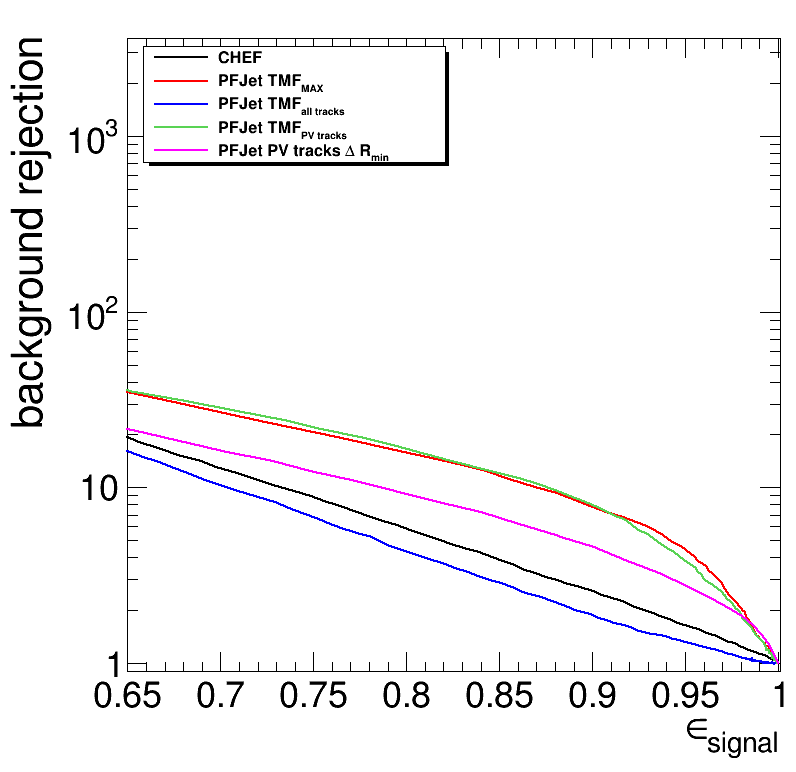

In [64]:
### ROC curve
# var = [CEF,calojetAlphaMax,calojetAlphaMax_jetpt,calojetBetaMax_EM,calojetBetaMax_Hadronic,calojetBetaMax]
# name = ['CEF','calojetAlphaMax','calojetAlphaMax_jetpt','calojetBetaMax_EM','calojetBetaMax_Hadronic','calojetBetaMax']


var_calo = [calojetGammaMax_P,calojetGammaMax_ET,calojetGammaMax,calojetMinDeltaRPVTracks]
axis_calo = [['Track Momentum Fraction','Events'],['Track p_{T} Fraction_{ET}','Events'],['Track p_{T} Fraction','Events'],['caloJet PV tracks #Delta R_{min}','Events']]
name_calo = ['calojetGammaMax_P','calojetGammaMax_ET','calojetGammaMax','calojetMinDeltaRPVTracks']
bins_calo = [[50,0,1],[50,0,1],[50,0,1],[50,0,1]]

var_pf = [CHEF,jetGammaMax_ET,jetTMF_all,jetTMF_pv,jetMinDeltaRPVTracks,]
axis_pf = [['CHEF','Events'],['PFJet TMF_{MAX}','Events'],['PFJet TMF_{all tracks}','Events'],['PFJet TMF_{PV tracks}','Events'],['PFJet PV tracks #Delta R_{min}','Events']]
name_pf = ['CHEF','pfjetGammaMax_ET','pfjetTMF_all','pfjetTMF_pv','pfjetMinDeltaRPVTracks']
bins_pf = [[50,0,1],[50,0,1],[50,0,1],[50,0,1],[50,0,1]]

sig_keys = ['bbbb_mh2000_ctau1','bbbb_mh125_ctau1','bbbb_mh2000_ctau10','bbbb_mh125_ctau10']
pt_cut = 20
calo = 0
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.18,0.79,0.56,0.94)
    leg.SetTextSize(0.022)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = np.array(range(1000))/100.0-5
#         print(np.max(thre),np.min(thre))
        for k in tree_bkg.keys():
#             if calo:
#                 sel = np.abs(calojetEta[k])<2.0
#                 sel = np.logical_and(sel,np.abs(calojetPt[k])>pt_cut)
#             else:
#                 sel = np.abs(jetEta[k])<2.0
#                 sel = np.logical_and(sel,np.abs(jetPt[k])>pt_cut)
#                 sel = np.logical_and(sel,jetRechitE[k]>10)

            v = var[i][k]
#             print(k,len(v),1.0*np.count_nonzero(sel)/len(var[i][k]))
            eff[k] = []
            for th in thre:
                if 'IP' in name[i] or 'MinDeltaR' in name[i]:
                    eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
                else:
                    eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
            eff[k] = np.array(eff[k])
        
    #Plotting s/sqrt(s+b)

    #     Plotting ROC curve
#         gr[name[i]] = create_TGraph(eff['QCD'],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])

        gr[name[i]] = create_TGraph(eff[sig_k][np.logical_not(eff['QCD']==0)],np.reciprocal(eff['QCD'][np.logical_not(eff['QCD']==0)]),axis_title = ['#epsilon_{signal}','background rejection'])
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].SetMarkerColor(std_color_list[i])

        gr[name[i]].SetMarkerColor(std_color_list[i])

    #     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
        gr[name[i]].GetXaxis().SetRangeUser(0.65, 1.0)


        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')
    leg.Draw()
    c.SetLogy()
    c.Draw()
    if calo:
        c.SaveAs('../plots/trackless/'+sig_k+'_caloROC2.png')

#         c.SaveAs('../plots/trackless_pt'+str(pt_cut)+'/'+sig_k+'_caloROC.pdf')
    else:
#         c.SaveAs('../plots/trackless_pt'+str(pt_cut)+'/'+sig_k+'_pfROC.pdf')
        c.SaveAs('../plots/trackless/'+sig_k+'_pfROC2.png')
